# Scratchpad

Thinking.

In [1]:
using Gadfly
using SymPy

In [2]:
include("ann.jl")

fillna (generic function with 1 method)

Looking at the sigmoid as the inverse of a shifted reflection of the exponential function:

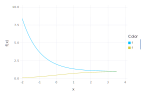

In [3]:
plot([x -> 1 / sigmoid(x), sigmoid], -2, 3.5)

negative log, as applied by negative log likelihood. consequently only relevant in [0, 1]:

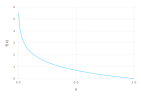

In [4]:
plot(x -> -log(x), 0, 1)

## Binary Logistic Regression

Let's take a look at the likelihood function and maximum likelihood over it. We have the random variables X, Y and Z. X can take on values between 1 and $256^{28^2}$, which is one value for each possible image. Y is 1 for the positive case, 0 otherwise. Z is a all of the possible hidden parameter vectors z. 

The likelihood for (data, label) observations then is $P(X,Y|Z)$. The likelihood of the whole dataset is the product of likelihoods for each instance. Maximum likelihood is then:

$$\underset{z}{argmax} \prod_{i=1}^m{ P(x^{(i)},y^{(i)}|z) }$$

A for a single instance, we have to calculate the likelihood for the the (data, label) observation:

In [5]:
@syms x z y positive=true
h = 1 ./ (1 + exp(-dot(z, x)))

    1    
---------
     -x*z
1 + e    

Depending on the value of y (0 or 1), we use the probility of the data being positive or negative respectively. We can combine this into a single expression as follows. It is best to combine the two cases for Y results in an expression that is purely made out of products. Those are more amenable to being cancelled by logs:

In [6]:
composed = simplify((h ^ y)* ((1 - h)^(1 - y)))

  x*y*z 
 e      
--------
 x*z    
e    + 1

To get the likelihood of our entire observed (image, label) dataset for a given z, we multiply the probabilities obtained above for each individual instance. Taking the negative log of that yields a sum of the following logs:

In [7]:
final = -1 * expand_log(log(composed))

            / x*z    \
-x*y*z + log\e    + 1/

Let's think about our full log likelihood function then. We have fixed (X,Y), which is our training data. So the full expression will have one NLL term per instance in the training set. Thus we can only write the likelihood for a fixed (x,y) list.

These terms will get added (since we took the log of the products to get the likelihood for the full trainset). 

Working:

$$-log \prod_{i=1}^m{ 
  \left(
      \frac{1}{ 1 + e^{ -x^{(i)} \cdot z } }
  \right)^{y^{(i)}}
  \left(
  1 - \frac{1}{ 1 + e^{ -x^{(i)} \cdot z } }
  \right)^{1 - y^{(i)}}
}$$

$$= - \sum_{i=1}^m{ 
  y^{(i)} log\frac{1}{ 1 + e^{ -x^{(i)} \cdot z } } 
  +
  (1 - y^{(i)}) log \left( 1 - \frac{1}{ 1 + e^{ -x^{(i)} \cdot z } }\right)
}$$

$$= - \sum_{i=1}^m{ 
  -y^{(i)} log(1 + e^{ -x^{(i)} \cdot z }) 
  +
  (1 - y^{(i)}) log \left(\frac{e^{ -x^{(i)} \cdot z }}{ 1 + e^{ -x^{(i)} \cdot z } }\right)
}$$

$$=  \sum_{i=1}^m{ 
  y^{(i)} log(1 + e^{ -x^{(i)} \cdot z }) 
  +
  (1 - y^{(i)}) log(1 + e^{ x^{(i)} \cdot z }) 
}$$

$$=  \sum_{i=1}^m{ 
  log(1 + e^{ x^{(i)} \cdot z }) 
  +
  y^{(i)} log(1 + e^{ -x^{(i)} \cdot z }) 
  -
  y^{(i)} log(1 + e^{ x^{(i)} \cdot z }) 
}$$

$$=  \sum_{i=1}^m{ 
  log(1 + e^{ x^{(i)} \cdot z }) 
  +
  y^{(i)} 
  log\left(\frac{1 + e^{ -x^{(i)} \cdot z } }{ 1 + e^{ x^{(i)} \cdot z } }\right)
}$$

$$=  \sum_{i=1}^m{ 
  log(1 + e^{ x^{(i)} \cdot z }) 
  +
  y^{(i)} log(e^{ -x^{(i)} \cdot z })
}$$

$$=  \sum_{i=1}^m{ 
  log(1 + e^{ x^{(i)} \cdot z }) - y^{(i)} x^{(i)} \cdot z
}$$

So we'd like to optimize the following objective:

$$ \underset{z}{argmin} \sum_{i=1}^m{ 
  log(1 + e^{ x^{(i)} \cdot z }) - y^{(i)} x^{(i)} \cdot z
}$$

### Optimization

The dot products in the objective can be considered in an splatted or unrolled form, as in $f(z_{1}, z_{2}..., z_{n}) = x_{1} \cdot z_{1} + x_{2} \cdot z_{2}... + x_{n} \cdot z_{n}$. When taking the partial derivate with respect to $z_{i}$, the result will be $x_{i}$. Now let's take the partial derivative of the objective with respect to $z_{j}$:

$$\frac{\partial}{\partial z_{j}} \left[log(1 + e^{ x^{(i)} \cdot z }) - y^{(i)} x^{(i)} \cdot z \right] $$

$$= \frac{1}{ 1 + e^{ x^{(i)} \cdot z } } \frac{\partial}{\partial z_{j}} (1 + e^{ x^{(i)} \cdot z }) - y^{(i)} x^{(i)}_{j} $$

$$= \frac{1}{ 1 + e^{ x^{(i)} \cdot z } } e^{ x_{i} \cdot z } \frac{\partial}{\partial z_{j}} (x^{(i)} z) - y^{(i)} x^{(i)}_{j} $$

$$= \frac{x^{(i)}_{j} e^{ x^{(i)} \cdot z } }{ 1 + e^{ x^{(i)} \cdot z } } - y^{(i)} x^{(i)}_{j} $$

This can be further manipulated to yield:

$$= x^{(i)}_{j} \frac{ e^{ x^{(i)} \cdot z } }{ 1 + e^{ x^{(i)} \cdot z } } - y^{(i)} x^{(i)}_{j} $$

$$= x^{(i)}_{j} \frac{1}{ 1 + e^{ -x^{(i)} \cdot z } } - y^{(i)} x^{(i)}_{j} $$

$$= x^{(i)}_{j} sig(x^{(i)} \cdot z) - y^{(i)} x^{(i)}_{j} $$

$$= x^{(i)}_{j}[sig(x^{(i)} \cdot z) - y^{(i)}] $$

### Implementation

### Numerical issues

As we can see, the gradient update requires computing $e^{ x^{(i)} \cdot z }$. We will overflow our floating point representation when $x^{(i)} \cdot z$ exceeds ~700. But the inner product of an image and a weight vector may very well exceed 700, given that grayscale values are [0, 255] per pixel, and the complete image is 728 pixels in this case.

We're going to ignore this, because for extremely large values of  $e^{ x^{(i)} \cdot z }$, the sigmoid evaluates to ~0. but 0/Inf == 0.

We'll also z-normalize the image data.

## Negative log likelihood behavior

Let's look at negative log likelikhood function, once when y = 1 and once when y = 0.

for y = 1, we will just have the negative log:

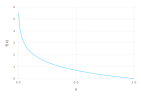

In [8]:
plot([x -> -log(x)], 0, 1)

The input to those are probabilities in the range [0, 1]. we can see that low probabilities are penalized at an exponentially increasing rate. 

Around the sigmoid, we get the following. Let's assume that the ingoing vectors are unit sized, then the dot product will be in the range of [-1, 1]. given those projections, we have the following cost:

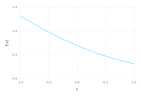

In [9]:
plot(x -> -log(sigmoid(x)), -1, 1)

Now for y = 0:

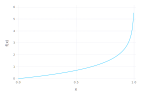

In [10]:
plot([x -> -log(1 - x)], 0, 1)

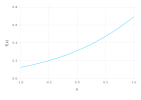

In [11]:
plot(x -> -log(sigmoid(1 - x)), -1, 1)

Here we have a large penalty if the probability is high, since we want to maximise for (x, ~y). Finally, the function over both values of y:

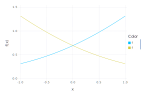

In [12]:
cost = (x, y) -> log(exp(x) + 1) - y*x
plot([x -> cost(x, 0), x -> cost(x, 1)], -1, 1)